# SDSS Uncertainty Image+Spectral Cube construction
In this notebook we show the methods in detail how do we construct the uncertainty cube from SDSS Spectra and images. The data used are DR12 images from Stripe 82 and spectra from TBD.

In [51]:
from astropy.io import ascii
import math
from pathlib import Path
from rasdapy.models.sinterval import SInterval
from rasdapy.db_connector import DBConnector
from rasdapy.query_executor import QueryExecutor
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from scripts import cubeUtils as utils
from importlib import reload
import h5py
import fitsio
reload(utils)
cube_utils = utils.CubeUtils("config/SDSS_Bands",
                                   "config/ccd_gain.tsv",
                                   "config/ccd_dark_variance.tsv")

test_image = "data/images/301/4797/1/frame-g-004797-1-0019.fits.bz2"    
test_spectrum = "data/spectra/spec-4500-55543-0331.fits"

img_header, img_data, file = utils.read_fits_file(test_image)
spec_data, spec_header = utils.read_spectrum(test_spectrum)

# Extracting uncertainty for image measurements.
In this step we extract the uncertainty for an SDSS image and plot all the intermediate by-products below. Steps involved:
1. Reading sky background from the FITS extension.
2. Interpolating the sky background to the image resolution.
3. Reading calibration vector and extending it to whole image (1D calibration vector works because of the way how SDSS continuously reads out the image).
4. Subtracting sky background and image calibration from the calibrated image, thus producing the Image before calibration in Detector Data Numbers.
5. Showing how we can calculate number of electrons from the data numbers - we don't need these for our error calculation.
6. Calculating Errors in the Data Numbers
7. Converting the Data Number errors to Nanomaggies (this is what we store in the uncertainty cube)
8. Showing the error to signal ratio - this plot demonstrates what we would expect - for brighter areas of the image we are more certain about the measurements than for dark areas.

0


/home/caucau/SDSSCube/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: divide by zero encountered in true_divide


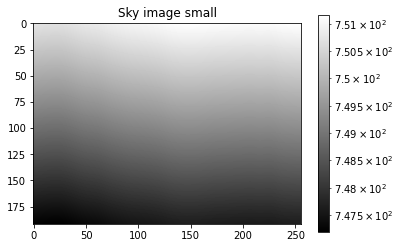

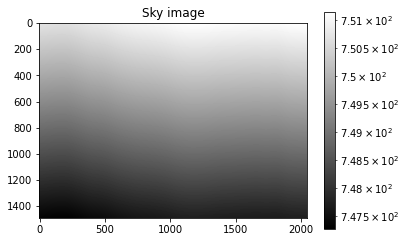

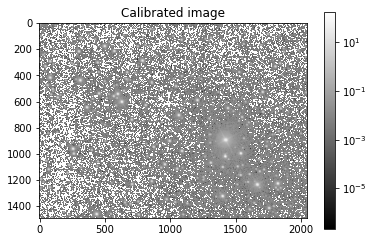

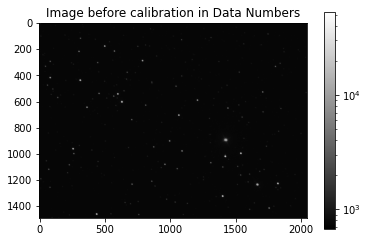

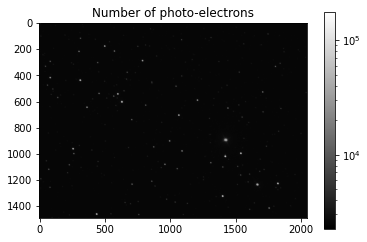

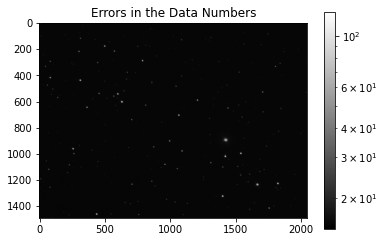

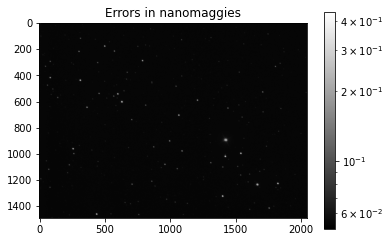

/home/caucau/SDSSCube/venv3/lib/python3.7/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


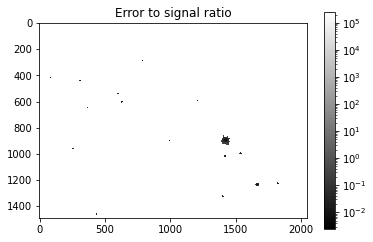

In [7]:
from scipy import interpolate
from pprint import pprint
import matplotlib.pyplot as plt
import itertools
import numpy as np

def draw_plots(img, img_err, allsky, simg, cimg, dn, nelec, dn_err, err_to_signal):
    plt.figure()
    plt.imshow(allsky, cmap='gray', norm=LogNorm())
    plt.colorbar()
    plt.title("Sky background small")

    plt.figure()
    plt.imshow(simg, cmap='gray', norm=LogNorm())
    plt.colorbar()
    plt.title("Sky background")

    plt.figure()
    plt.imshow(img, cmap='gray', norm=LogNorm())
    plt.colorbar()
    plt.title("Calibrated image")

    plt.figure()
    plt.imshow(dn, cmap='gray', norm=LogNorm())
    plt.colorbar()
    plt.title("Image before calibration in Data Numbers")

    plt.figure()
    plt.imshow(nelec, cmap='gray', norm=LogNorm())
    plt.colorbar()
    plt.title("Number of photo-electrons")

    plt.figure()
    plt.imshow(dn_err, cmap='gray', norm=LogNorm())
    plt.colorbar()
    plt.title("Errors in the Data Numbers")

    plt.figure()
    plt.imshow(img_err, cmap='gray', norm=LogNorm())
    plt.colorbar()
    plt.title("Errors in nanomaggies")

    plt.figure()
    plt.imshow(err_to_signal, cmap='gray', norm=LogNorm())
    plt.colorbar()
    plt.title("Error to signal ratio")

def get_image_with_errors(fitsPath):
    with fitsio.FITS(fitsPath) as f:
        fits_header = f[0].read_header()
        img = f[0].read()
        x_size = fits_header["NAXIS1"]
        y_size = fits_header["NAXIS2"]
        camcol = fits_header['CAMCOL']
        run = fits_header['run']
        band = fits_header['filter']    
        allsky = f[2]['allsky'].read()[0]
        xinterp = f[2]['xinterp'].read()[0]
        yinterp = f[2]['yinterp'].read()[0]


        gain = float(utils.get_config(ccd_gain_config, camcol, run, band))
        darkVariance = float(utils.get_config(ccd_dark_variance_config, camcol, run, band))

        grid_x, grid_y = np.meshgrid(xinterp, yinterp)

        orig_x, orig_y = np.meshgrid(np.arange(256),  np.arange(192))
        orig_coords = np.dstack((orig_y.ravel(), orig_x.ravel()))[0]

        simg = interpolate.griddata(orig_coords, allsky.ravel(), (grid_y, grid_x), method='nearest')

        calib = f[1].read()

        cimg = np.tile(calib, (y_size, 1)) #calibration image

        print(np.isnan(allsky).sum())


        dn = img /cimg + simg #data numbers

        nelec = dn*gain #number of electrons

        dn_err = np.sqrt(dn/gain + darkVariance) #data number errors

        img_err= dn_err*cimg  #image errors in nanomaggies

        err_to_signal = img_err / img
        
        return img, img_err, allsky, simg, cimg, dn, nelec, dn_err, err_to_signal
    
    
img, img_err, allsky, simg, cimg, dn, nelec, dn_err, err_to_signal = get_image_with_errors(testPath)
draw_plots(img, img_err, allsky, simg, cimg, dn, nelec, dn_err, err_to_signal)

# Extracting spectrum errors
For the spectrum the SDSS has made life much more easy for us as the inverse variance of the measurement is already stored in the fits files. We just need to convert both to nano-maggies to be able to compare it with image photometry, as it is in '1E-17 erg/cm^2/s/Ang'units.

/home/caucau/SDSSCube/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


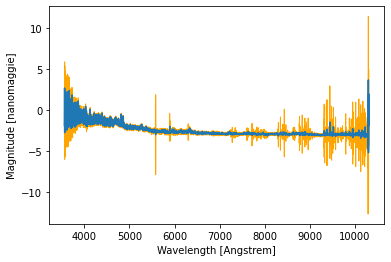

In [86]:
def plot_spec(fits_path):
    with fitsio.FITS(fits_path) as hdul:
        data = hdul[1].read()
        flux = data["flux"]
        flux_nm = -2.5/math.log(10) * (np.arcsinh(flux))
        var = flux_var_orig_res = np.divide(1, data["ivar"])
        var_nm = -2.5/math.log(10) * (np.arcsinh(var))
        wl = np.power(10, data["loglam"])
        ax = plt.axes(xlabel="Wavelength [Angstrem]", ylabel="Magnitude [nanomaggie]")
        ax.plot(wl, flux_nm)
        ax.fill_between(wl, flux_nm - var_nm, flux_nm + var_nm, color="orange")
        return wl, flux, var

spec_wl, spec_flux, spec_var = plot_spec(test_spectrum)

# Applying Filter transmission curves
We are not able to compare directly spectroscopic measurements with photometric ones. However, we can approximate this by applying the filter transmission curves to the spectrum and thus simulate values that would be measured to photon counts reduced by filter transmission function.

Below we show how the transmission curve looks like throught the whole spectrograph range. We take the transmission curves for individual filters and tak the maximum from each as this gets us close to values that we would measure by CCD through image filter.

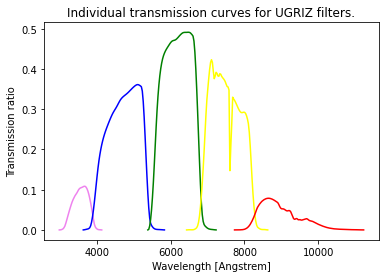

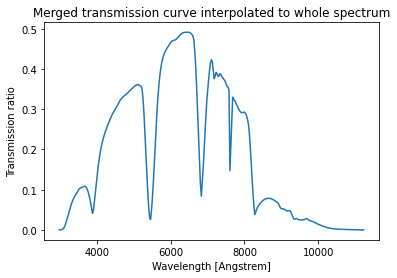

In [79]:
u = transmission_curves["u"]
g = transmission_curves["g"]
r = transmission_curves["r"]
i = transmission_curves["i"]
z = transmission_curves["z"]

merged_transmission_curve = cube_utils.merged_transmission_curve

wl, ratio = zip(*list(merged_transmission_curve.items()))
u_wl, u_ratio = zip(*list(u.items()))
g_wl, g_ratio = zip(*list(g.items()))
r_wl, r_ratio = zip(*list(r.items()))
i_wl, i_ratio = zip(*list(i.items()))
z_wl, z_ratio = zip(*list(z.items()))

plt.figure()
ax_u = plt.axes(xlabel="Wavelength [Angstrem]", ylabel="Transmission ratio")
ax_u = ax_u.plot(u_wl, u_ratio, color="violet")
ax_g = plt.plot(g_wl, g_ratio, color="blue")
ax_r = plt.plot(r_wl, r_ratio, color="green")
ax_i = plt.plot(i_wl, i_ratio, color="yellow")
ax_z = plt.plot(z_wl, z_ratio, color="red")
plt.title("Individual transmission curves for UGRIZ filters.")

plt.figure()
ax_merged = plt.axes(xlabel="Wavelength [Angstrem]", ylabel="Transmission ratio")
ax_merged = plt.plot(wl, ratio)
plt.title("Merged transmission curve interpolated to whole spectrum")

print()

# Applied transmission curve
This is how the spectrum looks like when the photometric transmission curve is applied. Be advised that we can do simple multiplication by the Merged transmission curve ratio, as we have same resolution.

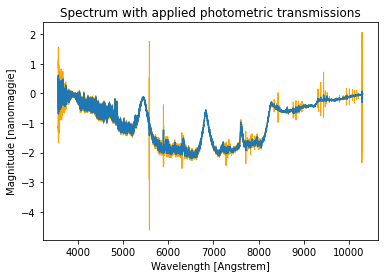

In [89]:

wl_trans, ratio_trans = zip(*list(merged_transmission_curve.items()))
transmission_spectrum_res = np.interp(spec_wl,
                                      wl_trans,
                                      ratio_trans)
flux_applied_trans = np.multiply(spec_flux, transmission_spectrum_res)
var_applied_trans = np.multiply(spec_var, transmission_spectrum_res)

flux_applied_trans_nm = -2.5/math.log(10) * (np.arcsinh(flux_applied_trans))
var_applied_trans_nm = -2.5/math.log(10) * (np.arcsinh(var_applied_trans))

ax = plt.axes(xlabel="Wavelength [Angstrem]", ylabel="Magnitude [nanomaggie]")
ax.plot(spec_wl, flux_applied_trans_nm)
ax.fill_between(spec_wl, 
                flux_applied_trans_nm - var_applied_trans_nm, 
                flux_applied_trans_nm + var_applied_trans_nm, 
                color="orange")
plt.title("Spectrum with applied photometric transmissions")
print()

In [ ]:
testSpectrum  = "data/spectra/spec-4500-55543-0331.fits"
MIN_RES = 256
reload(utils)

def plot_cube(resolution_cube):
    ax = plt.axes(xlabel="Wavelength", ylabel="Flux")
    ax.plot(wl, flux)
    ax.set_yscale('symlog')
    ax.fill_between(wl, flux - flux_err, flux + flux_err, facecolor="red")
    plt.title("Original spectrum with errors")

    plt.figure()
    ax1 = plt.axes(xlabel="Wavelength", ylabel="Flux")
    ax1.plot(wl, trans_flux)
    ax1.set_yscale('symlog')
    ax1.fill_between(wl, trans_flux - trans_flux_err, trans_flux + trans_flux_err, facecolor="red")
    plt.title("Spectrum calibrated by photometric system transmission.")

    plt.figure()
    ax2 = plt.axes(xlabel="Wavelength", ylabel="Flux")
    ax2.plot(wl_low, flux_low)
    ax2.set_yscale('symlog')
    ax2.fill_between(wl_low, flux_low - flux_err_low, flux_low + flux_err_low, facecolor="red")
    plt.title("Interpolated lower resolution spectrum")
    

expected_spectra_resolutions = [4620, 2310, 1155, 577, 288]
MIN_RES = 256

fits_header, multiple_res_cube = self.cube_utils.get_multiple_resolution_spectrum(test_spectrum,
                                                                                  MIN_RES,
                                                                                  apply_transmission=False)
lower_res_cube = utils.process_spectrum(testSpectrum, merged_transmission_curve, MIN_RES, apply_transmission=False)
lower_res_cube_with_transmission = utils.process_spectrum(testSpectrum, merged_transmission_curve, MIN_RES)

print(lower_res_cube)






        
        
        

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
from astropy import wcs

import dask, xarray
#print('dask',dask.__version__, 'xarray',xarray.__version__)

import xarray as xr

def get_image_coords(fits_header):
    w = wcs.WCS(fits_header)
    NAXIS1 = fits_header["NAXIS1"]
    NAXIS2 = fits_header["NAXIS2"]
    x = np.arange(NAXIS1)
    y = np.arange(NAXIS2)
    X, Y = np.meshgrid(x, y)
    return w.wcs_pix2world(X, Y, 0)  #returns ra, dec arrays.



DEFAULT_RES = 0
IMAGE_SPECTRAL_RES = 6  #number of image bands
xr.set_options(display_style="html")
img, img_err
x_res = img.shape[1]
y_res = img.shape[0]

ra_coords, dec_coords = get_image_coords(fits_header)
print (ra_coords.shape)
date_time_str = ("%s %s" %(fits_header["DATE-OBS"], fits_header["TAIHMS"]))
image_date_time_obs = datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S.%f')
band = fits_header["FILTER"]
wavelength = filter_midpoints[band]
wl_res = 6 

img_6d = np.array (img) [:, :,  np.newaxis, np.newaxis, np.newaxis, np.newaxis, np.newaxis]
img_err_6d = np.array (img_err) [:, :,  np.newaxis, np.newaxis, np.newaxis, np.newaxis, np.newaxis]
print(img_6d.shape)

img_ds = xr.Dataset({'flux_mean': (['x', 'y', 'date_time', 'wavelength', 'x_res', 'y_res', 'wl_res'], img_6d),
                 'flux_variance': (['x', 'y', 'date_time', 'wavelength', 'x_res', 'y_res', 'wl_res'], img_err_6d)},
                coords={'ra': (['x', 'y'], ra_coords),
                        'dec': (['x', 'y'], dec_coords),
                        'date_time': [image_date_time_obs],
                        'wavelength': [wavelength],
                        'x_res': [x_res], 
                        'y_res': [y_res], 
                        'wl_res': [IMAGE_SPECTRAL_RES]})



img_ds.to_netcdf(path="test_image_cdf.nc")
#from matplotlib.colors import LogNorm



#plt.imshow(fits_data, cmap='gray', norm=LogNorm())
#plt.colorbar()

img_ds




In [ ]:
from astropy import time

wl, flux, flux_err

plate_obs_date_time = time.Time(spectrum_header["MJD"], format='mjd', out_subfmt='date_hms').datetime
print(plate_obs_date_time)
ra = [[spectrum_header['PLUG_RA']]]     # to match the image-like x,y coordinates
dec = [[spectrum_header['PLUG_DEC']]]   # to match the image-like x,y coordinates
wavelength = wl
wl_res = len(wl)
x_res = 1    #only one object observed
y_res = 1    #only one object observed

spec_6d = np.array (flux) [np.newaxis, np.newaxis, np.newaxis, :, np.newaxis, np.newaxis, np.newaxis]
spec_err_6d = np.array (flux_err) [np.newaxis, np.newaxis, np.newaxis, :, np.newaxis, np.newaxis, np.newaxis]
print(spec_6d.shape)

spec_ds = xr.Dataset({'flux_mean': (['x', 'y', 'date_time', 'wavelength', 'x_res', 'y_res', 'wl_res'], spec_6d),
                 'flux_variance': (['x', 'y', 'date_time', 'wavelength', 'x_res', 'y_res', 'wl_res'], spec_err_6d)},
                coords={'ra': (['x', 'y'], ra),
                        'dec': (['x', 'y'], dec),
                        'date_time': [plate_obs_date_time],
                        'wavelength': wavelength,
                        'x_res': [x_res], 
                        'y_res': [y_res], 
                        'wl_res': [wl_res]})



spec_ds.to_netcdf(path="test_spectrum_cdf.nc")
#from matplotlib.colors import LogNorm



#plt.imshow(fits_data, cmap='gray', norm=LogNorm())
#plt.colorbar()

spec_ds

In [ ]:
xarray.concat(spec_ds.sizes['wavelength'] * [img_ds], dim='wavelength')


In [ ]:
db_setup_sql = "setupDB.sql"
db_connector = DBConnector("localhost", 7001, "rasadmin", "rasadmin")
query_executor = QueryExecutor(db_connector)
db_connector.open()

query_drop1 = r"""drop collection cube""";
query_drop2 = r"""drop type GaussianMeasurement""";
query_drop3 = r"""drop type GaussianCube""";
query_drop4 = r"""drop type GaussianMeasurement""";


query1 = r"""create type GaussianMeasurement
	as ( mean float, 
		variance float)""";

query2 = r"""create type GaussianCube 
	as GaussianMeasurement mdarray [ra, dec, time, spectral, res]""";

query3 = r"""create type GaussianCubeSet 
	as set (GaussianCube)""";

query4 = r"""create collection cube GaussianCubeSet""";

query5 = r"""select r from RAS_COLLECTIONNAMES as r """;


with open(db_setup_sql, 'r') as file:
    query = file.read()
try:
    
    #query_executor.execute_write(query_drop1)
    #query_executor.execute_write(query_drop2)
    #query_executor.execute_write(query_drop3)
    #query_executor.execute_write(query_drop4)
    #query_executor.execute_write(query1)
    query_executor.execute_write(query2)
    query_executor.execute_write(query3)
    query_executor.execute_write(query4)
    result = query_executor.execute_read(query5)
    
    
    
    #numpy_array = result.to_array()
    print(result)
finally:
    db_connector.close()



In [ ]:
import numpy as np
from astropy import wcs
from astropy.io import fits
import sys
from astropy.coordinates import SkyCoord


w = wcs.WCS(fits_header)
print (w)
ra_left, dec_top = w.wcs_pix2world(0, 0, 1)

ra_right, dec_bot = w.all_pix2world(fits_header["NAXIS1"], fits_header["NAXIS2"], 1)

print ("px: %f py: %f" %(ra_left, dec_top ))
print ("p2x: %f p2y: %f" %(ra_right, dec_bot))


coord_top_left = SkyCoord.from_pixel(0,0,w)
#coord_top_left.representation_type = 'cartesian'
print(coord_top_left)

coord_bot_left = SkyCoord.from_pixel(0,fits_header["NAXIS2"],w)
coord_bot_left.representation_type = 'cartesian'
print(coord_bot_left)

coord_top_right = SkyCoord.from_pixel(fits_header["NAXIS1"],0,w)
coord_top_right.representation_type = 'cartesian'
print(coord_top_right)

coord_bot_right = SkyCoord.from_pixel(fits_header["NAXIS1"],fits_header["NAXIS2"],w)
coord_bot_right.representation_type = 'cartesian'
print(coord_bot_right)


ra_left, dec_top = w.wcs_pix2world(0, 0, 1)
ra_right, dec_bot = w.all_pix2world(fits_header["NAXIS1"], fits_header["NAXIS2"], 1)

print ("px: %f py: %f" %(ra_left, dec_top ))
print ("p2x: %f p2y: %f" %(ra_right, dec_bot))

In [ ]:
import healpy as hp
import datetime
import numpy as np

RES_ORDER = 19
NSIDE = 2**RES_ORDER
NPIX = hp.nside2npix(NSIDE)



time_epoch = fits_header["TAI"]
band = fits_header["FILTER"]
spec = filter_midpoints[band]
res = RES_ORDER

date_time = ("%s %s" %(fits_header["DATE-OBS"], fits_header["TAIHMS"]))
datetime.datetime.strptime(date_time, '%Y-%m-%d %H:%M:%S.%f')



NAXIS1 = fits_header["NAXIS1"]
NAXIS2 = fits_header["NAXIS2"]
x = np.arange(NAXIS1)
y = np.arange(NAXIS2)
X, Y = np.meshgrid(x, y)
ra, dec = w.wcs_pix2world(X, Y, 0)




fig = plt.figure(num=None, figsize=(20, 14), dpi=80, facecolor='w', edgecolor='k')
step = 100
plt.scatter(ra[::step, ::step], dec[::step, ::step])
plt.grid()
plt.set_xticks(np.arange(0, 100, 20))
plt.set_yticks(np.arange(0, 100, 20))

plt.show()



#pixelIDs = hp.ang2pix(NSIDE, ra, dec, lonlat=True)
#print (pixelIDs)

#dict_table = dict(zip(pixelIDs, fits_data))
#print (dict_table)






#pixelID = hp.ang2pix(NSIDE, ra, dec, lonlat=True)
#ipix_image[index[0]*index[1]] = pixelID
    

#np.array()

#print (pixel)


In [ ]:

print ("NPIX: %d" %NPIX)
m = np.arange(NPIX)
print (m)

vec = hp.ang2vec(np.pi / 2, np.pi * 3 / 4)
print(vec)

ipix_disc = hp.query_disc(nside=32, vec=vec, radius=np.radians(10))
m = np.arange(NPIX)
m[ipix_disc] = m.max()
hp.mollview(m, nest=True, title="Mollview image RING")

In [ ]:
query1 = r"""insert into cube values marray it in [0:0, 0:0, 0:0, 0:0, 0:0] values {0.0f, 0.0f} """;
query2 = "update cube as c set c assign shift(decode($1), [%f, %f])" %

print(fits_data)
try:
    db_connector.open()
    query_executor.execute_write(query1)    
    query_executor.execute_write(query2, fits_data)
finally:
    db_connector.close()

In [ ]:
print (type(fits_data))
print(fits_data.shape)




plt.imshow(fits_data, cmap='gray', norm=LogNorm())
plt.colorbar()

In [ ]:
fits_subset = fits_data[850:900, 1350:1450]

plt.imshow(fits_subset, cmap='gray', norm=LogNorm())
plt.colorbar()